In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

In [10]:
from decouple import config
from dotenv import load_dotenv

load_dotenv()
api_key = config("ALPHA_VANTAGE_API_KEY")
GROQ_API_KEY = config("GROQ_API_KEY")

symbol = "NVDA"

In [ ]:

from typing_extensions import Annotated
from loguru import logger
import requests
import uuid
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import pickle
import os
import io
from PIL import Image as PilImage
import base64

from fpdf import FPDF
import seaborn as sns
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.runnables import RunnableConfig 
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import ToolMessage
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
from pydantic import BaseModel, Field
from IPython.display import Image, display
from yahooquery import search
import yfinance as yf
from tabulate import tabulate

class State(AgentState):
    ticker: str
    raw_data: str
    enriched_data: str
    model: bytes
    diagnostics: dict
    test_forecast: str
    future_forecast: str
    line_plot: bytes
    report: dict
    insights: str
    pdf_report: bytes

llm = init_chat_model( 
    model="llama-3.3-70b-versatile", 
    model_provider="groq",
    temperature=0.4,
    api_key=GROQ_API_KEY,
)

# Tool to fetch stock ticker
@tool
def stock_ticker_tool(
    company_name: str,
    tool_call_id: Annotated[str, InjectedToolCallId], 
    config: RunnableConfig    
) -> Command:
    """Retrieves the stock ticker symbol for a given public company name from Yahoo Finance.
    Example input: 'Apple'
    Example output: 'AAPL'"""
    try:
        search_results = search(company_name)  # Perform Yahoo Finance search
        
        if "quotes" in search_results:
            for quote in search_results["quotes"]:
                if "symbol" in quote:
                    ticker = quote["symbol"]
                    return Command(
                        update={
                            "ticker": ticker,  # Update ticker in state
                            "messages": [
                                ToolMessage(
                                    f"Successfully added {company_name}'s ticker symbol to State", 
                                    tool_call_id=tool_call_id
                                )
                            ]
                        },
                    )
        # Always return a Command even if not found.
        return Command(
            update={
                "ticker": "",
                "messages": [ToolMessage(f"Ticker for {company_name} not found.", tool_call_id=tool_call_id)]
            },
        )
    except Exception as e:
        return Command(
            update={
                "ticker": "",
                "messages": [ToolMessage(f"Error retrieving ticker: {str(e)}", tool_call_id=tool_call_id)]        
            },
        )


# Bind LLM with the tool
llm_with_tools = llm.bind_tools([stock_ticker_tool])

tools = [stock_ticker_tool]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)
    

#########################################
# Node 1: Data Ingestion
#########################################

def data_ingestion_node(state: State, config: RunnableConfig):
    """
    Retrieve daily stock data using yfinance and update state.
    The data is stored as a JSON string.
    """
    symbol = state['ticker']
    logger.info(f"Ingesting data for {symbol}.")
    
    try:
        # Retrieve stock data using yfinance; get maximum historical data.
        stock = yf.Ticker(symbol)
        # Fetch historical data; you can adjust period (e.g., "max", "5y", etc.)
        df = stock.history(period="9mo")
        
        # Ensure that the DataFrame has a datetime index.
        df.index = pd.to_datetime(df.index)
        
        # Select required columns and rename them to lowercase for consistency.
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df.sort_index(inplace=True)
        
        # Convert DataFrame to a JSON string (which is serializable; a requirement to save in State).
        raw_data = df.to_json(orient="records", date_format="iso")
        logger.info(f"Raw data ingested: {len(df)} records.")
        return {"raw_data": raw_data}
    except Exception as e:
        logger.exception(f"Data ingestion error: {e}")


#########################################
# Node 2: Data Enrichment
#########################################
def data_enrichment_node(state: State, config: RunnableConfig):
    """
    Enrich the raw stock data with technical indicators, additional features,
    and aggregated news sentiment.
    Updates state.enriched_data.
    """
    raw_data = state["raw_data"]
    logger.info("Enriching data")
    if raw_data is None:
        logger.error("No raw data available for enrichment.")
        return None
    if len(raw_data) < 60:
        logger.error("Insufficient raw data for reliable enrichment.")
        return None
    
    raw_df = pd.read_json(StringIO(raw_data))
    logger.info(f"Enriching data for {len(raw_df)} records.")

    # --- Technical Indicators and Additional Features ---
    def enrich_with_technical_indicators(df):
        """
        Calculate technical indicators:
        - SMA (20-day)
        - EMA (20-day)
        - MACD and Signal Line
        - RSI (14-day)
        - Bollinger Bands (20-day)
        And additional calculations:
        - Daily returns, log returns
        - Volatility (rolling std of daily returns over 20 days)
        - Daily price range
        - Rolling average volume and percentage change in volume
        """
        enriched_df = df.copy()
        
        # --- Simple Moving Average (SMA) ---
        sma_window = 20
        enriched_df[f'sma_{sma_window}'] = enriched_df['close'].rolling(window=sma_window).mean()
        
        # --- Exponential Moving Average (EMA) ---
        ema_span = 20
        enriched_df[f'ema_{ema_span}'] = enriched_df['close'].ewm(span=ema_span, adjust=False).mean()
        
        # --- MACD ---
        ema_short = enriched_df['close'].ewm(span=12, adjust=False).mean()
        ema_long = enriched_df['close'].ewm(span=26, adjust=False).mean()
        enriched_df['macd'] = ema_short - ema_long
        enriched_df['macd_signal'] = enriched_df['macd'].ewm(span=9, adjust=False).mean()
        
        # --- Relative Strength Index (RSI) ---
        delta = enriched_df['close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        rsi_period = 14
        avg_gain = gain.rolling(window=rsi_period).mean()
        avg_loss = loss.rolling(window=rsi_period).mean()
        rs = avg_gain / avg_loss
        enriched_df['rsi'] = 100 - (100 / (1 + rs))
        
        # --- Bollinger Bands ---
        std = enriched_df['close'].rolling(window=sma_window).std()
        enriched_df['bollinger_upper'] = enriched_df[f'sma_{sma_window}'] + (2 * std)
        enriched_df['bollinger_lower'] = enriched_df[f'sma_{sma_window}'] - (2 * std)

        # --- Additional Calculations ---
        enriched_df['return_pct'] = enriched_df['close'].pct_change()            # Daily returns (percentage change)
        enriched_df['log_return'] = np.log(enriched_df['close']).diff()           # Log returns
        enriched_df['volatility'] = enriched_df['return_pct'].rolling(window=sma_window).std()  # Rolling volatility
        enriched_df['price_range'] = enriched_df['high'] - enriched_df['low']       # Daily price range
        enriched_df['avg_volume_20'] = enriched_df['volume'].rolling(window=sma_window).mean()   # 20-day rolling average volume
        enriched_df['volume_change'] = enriched_df['volume'].pct_change()           # Volume percentage change
        
        return enriched_df

    enriched_df = enrich_with_technical_indicators(raw_df)
    if enriched_df is None:
        logger.error("Enrichment failed.")
        raise ValueError("Enrichment failed.")
    enriched_df.dropna(inplace=True)
    logger.info(f"Data enriched: {len(enriched_df)} records available.")
    enriched_data = enriched_df.to_json(orient="records", date_format="iso")
    return {"enriched_data": enriched_data}

#########################################
# Node 3: Model Training & Evaluation
#########################################

def model_training_evaluation_node(
        state: State, 
        config: RunnableConfig,
        test_size: float = 0.2, 
        forecast_periods: int = 5,
    ):
    """
    Split enriched data into training and test sets, train an Auto ARIMA model with exogenous variables,
    evaluate its performance, generate diagnostic plots, and produce future forecasts.
    
    Updates state with pickled model, diagnostics, test forecast, future forecast, and line plot.
    If critical data is missing, returns an error string so the LLM can decide what to do next.
    """
    enriched_data = state.get("enriched_data")
    if not enriched_data:
        error_msg = "No enriched data available for model training."
        logger.error(error_msg)
        return {"error": error_msg}

    try:
        enriched_df = pd.read_json(StringIO(enriched_data), orient="records")
    except Exception as e:
        error_msg = f"Error reading enriched data: {str(e)}"
        logger.error(error_msg)
        return {"error": error_msg}
        
    logger.info(f"Training model with {len(enriched_df)} records.")
    if enriched_df.empty:
        error_msg = "Enriched data is empty."
        logger.error(error_msg)
        return {"error": error_msg}

    exog_columns = [
        'sma_20', 'ema_20', 'macd', 'macd_signal', 'rsi',
        'bollinger_upper', 'bollinger_lower',
        'return_pct', 'log_return', 'volatility', 'price_range',
        'avg_volume_20', 'volume_change'
    ]
    enriched_df = enriched_df.dropna(subset=['close'] + exog_columns)
    if enriched_df.empty:
        error_msg = "No valid data after dropping NaNs."
        logger.error(error_msg)
        return {"error": error_msg}

    train_df, test_df = train_test_split(enriched_df, test_size=test_size)
    target_train = train_df['close']
    exog_train = train_df[exog_columns]
    
    logger.info("Training Auto ARIMA model.")
    model = pm.auto_arima(
        target_train,
        exogenous=exog_train,
        seasonal=True,
        m=5,  # assuming 5 trading days per week
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Save the initial model (pickled) into state before any human interruption.
    state["model"] = pickle.dumps(model)
    logger.info("Model saved to state. (Pre-interrupt state)")
    
    exog_test = test_df[exog_columns]
    n_test = len(test_df)
    forecast_test, conf_int = model.predict(n_periods=n_test, exogenous=exog_test, return_conf_int=True)
    test_forecast_df = pd.DataFrame({"actual": test_df["close"], "forecast": forecast_test}, index=test_df.index)
    
    mae = float(np.mean(np.abs(test_df["close"] - forecast_test)))  # Convert to native float
    logger.info(f"Test MAE: {mae}")
    
    # Generate diagnostic plots (2x2 grid)
    fig_diag = model.plot_diagnostics(figsize=(10, 8))
    buf_diag = BytesIO()
    fig_diag.savefig(buf_diag, format="png")
    plt.close(fig_diag)
    buf_diag.seek(0)

    # View the diagnostic plots in the notebook.
    display(Image(buf_diag.getvalue()))
    
    diagnostics = {
        "MAE": mae,
        "model_summary": model.summary().as_text(),
        "diagnostic_plot": buf_diag.getvalue()
    }

    # Generate a line graph plot showing historical (train), test, and forecast values.
    fig_line, ax_line = plt.subplots(figsize=(10, 5))
    ax_line.plot(train_df.index, train_df['close'], label='Train', color='blue')
    ax_line.plot(test_df.index, test_df['close'], label='Test', marker='o', linestyle='--', color='green')
    ax_line.plot(test_df.index, forecast_test, label='Prediction', marker='x', linestyle='-', color='red')
    ax_line.set_title("Historical (Train), Test and Prediction")
    ax_line.legend()
    buf_line = BytesIO()
    fig_line.savefig(buf_line, format="png")
    plt.close(fig_line)
    buf_line.seek(0)

    # View the line plot in the notebook.
    display(Image(buf_line.getvalue()))

    # Merge line_plot into state separately.
    state["line_plot"] = buf_line.getvalue()
    
    # Retrain model on full data for future forecasting.
    target_full = enriched_df['close']
    exog_full = enriched_df[exog_columns]
    model_full = pm.auto_arima(
        target_full,
        exogenous=exog_full,
        seasonal=True,
        m=5,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    # For forecasting, use the last 'forecast_periods' rows.
    future_exog = exog_full.iloc[-forecast_periods:]
    future_forecast = model_full.predict(n_periods=forecast_periods, exogenous=future_exog)
    logger.info(f"Future forecast: {future_forecast}")

    future_forecast_series = pd.Series(future_forecast.tolist(), name="forecast")
    future_forecast_series.index = pd.Index([f"Day {i+1}" for i in range(len(future_forecast))])
    ff_dict = {str(k): float(v) for k, v in future_forecast_series.to_dict().items()}
    logger.info(ff_dict)

    # Save the full retrained model.
    state["model"] = pickle.dumps(model_full)
    
    return {
        "model": pickle.dumps(model_full), 
        "future_forecast": ff_dict,
        "diagnostics": diagnostics,
        "test_forecast": test_forecast_df.to_json(date_format='iso'),
        "line_plot": buf_line.getvalue()
    }


#########################################
# Node 4: Report Generation & Insights Node
#########################################

def report_generation_node(state: State, config: RunnableConfig):
    """
    Generate a report with visualizations and a PDF document based on model forecasts, diagnostics, and enriched data.
    """
    enriched_data = state.get("enriched_data")
    forecast_data = state.get("future_forecast")
    diagnostics = state.get("diagnostics")
    line_plot = state.get("line_plot")
    ticker = state.get('ticker')

    if enriched_data is None or forecast_data is None or diagnostics is None:
        logger.error(f"❌ Insufficient data for {ticker} report generation.")
        return None

    # Rehydrate enriched_data from JSON using StringIO
    enriched_df = pd.read_json(StringIO(enriched_data), orient="records")
    recent_data = enriched_df.tail(20)

    # Extract MAE value
    mae_value = diagnostics.get('MAE', 'N/A')
    mae_str = f"{mae_value:.2f}" if isinstance(mae_value, (int, float)) else "N/A"

    # Create directory for temporary images
    temp_img_dir = "temp_images"
    os.makedirs(temp_img_dir, exist_ok=True)

    # Retrieve the diagnostic plot bytes from state
    diag_img_bytes = diagnostics.get("diagnostic_plot")

    if diag_img_bytes is None:
        logger.error("❌ Diagnostic plot bytes not found in state.")
        return None
    # Rehydrate the image from bytes
    diag_img = PilImage.open(io.BytesIO(diag_img_bytes))

    # Save the image properly
    diag_img_path = os.path.join(temp_img_dir, f"{ticker}_diagnostic_plot.png")
    diag_img.save(diag_img_path)

    # 📌 Retrieve the forecast line plot bytes from state
    if line_plot is None:
        logger.error("❌ Forecast line plot bytes not found in state.")
        return None

    # 📌 Rehydrate the forecast line plot image from bytes
    line_plot_img = PilImage.open(io.BytesIO(line_plot))

    # 📌 Save the forecast line plot image
    line_plot_forecast_path = os.path.join(temp_img_dir, f"{ticker}_forecast_plot.png")
    line_plot_img.save(line_plot_forecast_path)
    

    # 📌 **Generate Visualizations**
    ## ✅ Bollinger Bands Plot
    bollinger_plot_path = os.path.join(temp_img_dir, f"{ticker}_bollinger_plot.png")
    plt.figure(figsize=(12, 6))
    plt.plot(enriched_df.index, enriched_df["close"], label="Close Price", color="blue")
    plt.plot(enriched_df.index, enriched_df["bollinger_upper"], label="Upper Band", linestyle="dashed", color="red")
    plt.plot(enriched_df.index, enriched_df["bollinger_lower"], label="Lower Band", linestyle="dashed", color="green")
    plt.fill_between(enriched_df.index, enriched_df["bollinger_upper"], enriched_df["bollinger_lower"], color="gray", alpha=0.2)
    plt.title(f"{ticker} Bollinger Bands Analysis")
    plt.legend()
    plt.savefig(bollinger_plot_path)
    plt.close()

    ## ✅ Line Plot with Moving Averages
    line_plot_path = os.path.join(temp_img_dir, f"{ticker}_line_plot.png")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=enriched_df, x=enriched_df.index, y="close", label="Close Price")
    sns.lineplot(data=enriched_df, x=enriched_df.index, y="sma_20", label="SMA 20")
    sns.lineplot(data=enriched_df, x=enriched_df.index, y="ema_20", label="EMA 20")
    plt.title(f"{ticker} Stock Price with Moving Averages")
    plt.legend()
    plt.savefig(line_plot_path)
    plt.close()

    ## ✅ MACD Plot
    macd_plot_path = os.path.join(temp_img_dir, f"{ticker}_macd_plot.png")
    plt.figure(figsize=(12, 4))
    plt.plot(enriched_df.index, enriched_df["macd"], label="MACD", color="blue")
    plt.plot(enriched_df.index, enriched_df["macd_signal"], label="Signal Line", color="red")
    plt.title(f"{ticker} MACD and Signal Line")
    plt.legend()
    plt.savefig(macd_plot_path)
    plt.close()

    ## ✅ Volume Trend Plot
    volume_plot_path = os.path.join(temp_img_dir, f"{ticker}_volume_plot.png")
    plt.figure(figsize=(12, 4))
    plt.bar(enriched_df.index, enriched_df["volume"], color="gray")
    plt.title(f"{ticker} Trading Volume Trend")
    plt.savefig(volume_plot_path)
    plt.close()

    if isinstance(forecast_data, dict):
        # Convert dict to a list of tuples for tabulate
        forecast_table = tabulate(forecast_data.items(), headers=["Day", "Predicted Price"], tablefmt="fancy_grid")
    else:
        forecast_table = str(forecast_data)  # Fallback in case it's an unexpected format

    logger.info(f"Forecast table: {forecast_table}")

    # 📌 **Report Text**
    report_text = (
        f"{ticker} Financial Market Analysis Report\n\n"
        f"Price Forecast for the Next Week (5 Business Days):\n"
        f"{forecast_table}\n\n"
        f"Model Evaluation (MAE): {mae_str}\n\n"
        "Please review the diagnostic plots for further insights."
    )

    recent_data_str = recent_data.to_string() if recent_data is not None else "Recent data unavailable."

    # 📌 **LLM Prompt for Insights**
    prompt = f"""
    Analyze the following financial data for {ticker}:
    
    Recent Stock Performance (last 20 records):
    {recent_data_str}
    
    Price Forecast for Next Week (5 Business Days):
    {forecast_data}
    
    Provide comprehensive market insights including:
    1. Current market trend,
    2. Potential investment risks,
    3. Short-term price movement prediction,
    4. Recommendations for investors.
    """
    
    try:
        response = llm_with_tools.invoke([{"role": "user", "content": prompt}])
        insights = response.content
        
        # 📌 **Generate PDF Report**
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.add_page()
        pdf.set_font("Arial", size=12)

        pdf.cell(200, 10, f"{ticker} Financial Market Analysis Report", ln=True, align="C")
        pdf.ln(10)
        pdf.multi_cell(0, 10, report_text)
        pdf.ln(10)

        # 📌 **Add Insights to PDF**
        pdf.set_font("Arial", style="B", size=12)
        pdf.cell(0, 10, "AI-Powered Market Insights", ln=True)
        pdf.set_font("Arial", size=12)
        pdf.multi_cell(0, 10, str(insights))

        # 📌 Add Plots to PDF
        def add_plot_page(pdf, title, image_path):
            pdf.add_page()
            pdf.cell(200, 10, title, ln=True, align="C")
            pdf.image(image_path, x=10, y=None, w=180)

        add_plot_page(pdf, f"{ticker} Stock Price with Moving Averages", line_plot_path)
        add_plot_page(pdf, f"{ticker} MACD Analysis", macd_plot_path)
        add_plot_page(pdf, f"{ticker} Volume Trend", volume_plot_path)
        add_plot_page(pdf, f"{ticker} Bollinger Bands Analysis", bollinger_plot_path)
        add_plot_page(pdf, f"{ticker} Model Diagnostic Plot", diag_img_path)
        add_plot_page(pdf, f"{ticker} Forecast Plot", line_plot_forecast_path)

        # 📌 Save PDF
        pdf_path = os.path.join(temp_img_dir, f"{ticker}_financial_report.pdf")
        pdf.output(pdf_path)

        # 📌 Update Report Dictionary
        report = {
            "text": report_text,
            "diagnostic_plot": diag_img_path,
            "forecast_plot": line_plot_forecast_path,
            "line_plot": line_plot_path,
            "macd_plot": macd_plot_path,
            "volume_plot": volume_plot_path,
            "bollinger_plot": bollinger_plot_path,
            "pdf_report": pdf_path
        }

        logger.info(f"✅ Report generation for {ticker} completed.")
        logger.info(f"📌 Insights for {ticker}: {insights}")

        return {"report": report, "insights": insights}
    
    except Exception as e:
        logger.error(f"❌ Market insights generation error for {ticker}: {str(e)}")
        return None
    

def human_review_node(state: State, config: RunnableConfig):
    """
    Interrupt the workflow to allow an analyst to review the generated report and insights,
    and provide feedback (e.g., edited insights). The feedback is then merged into the state.
    """
    # Prepare a payload that includes the report summary and AI-generated insights
    payload = {
        "task": "Review the generated report and provide feedback.",
        "report_summary": state.get("report", {}).get("text", ""),
        "pdf_report": state.get("report", {}).get("pdf_report", ""),
        "ai_insights": state.get("insights", "")
    }
    
    # Trigger an interrupt that will pause execution and surface the payload to the analyst.
    # The workflow will wait until the analyst provides a response.
    result = interrupt(payload)
    
    # The expected response from the analyst is a dict containing an "edited_text" field.
    edited_text = result.get("edited_text", state.get("insights", ""))
    
    # Update the state with the analyst's feedback (edited insights)
    return {"insights": edited_text}
    
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


In [136]:
graph = StateGraph(State)

# Tool-calling part: to sequentially invoke the YouTube tools if needed.
# Add nodes.
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)
graph.add_node("ingestion", data_ingestion_node)
graph.add_node("enrichment", data_enrichment_node)
graph.add_node("model_train_eval", model_training_evaluation_node)
graph.add_node("report_generation", report_generation_node)
graph.add_node("human_review", human_review_node)

# Add edges.
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", tools_condition)
graph.add_edge("tools", "agent")  # After executing tools, return to the agent.
graph.add_edge("agent", "ingestion")
graph.add_edge("ingestion", "enrichment")
graph.add_edge("enrichment", "model_train_eval")
graph.add_edge("model_train_eval", "report_generation")
graph.add_edge("report_generation", "human_review")
graph.add_edge("human_review", END)

# Set up memory
memory = MemorySaver()
thread = uuid.uuid4()
config = {"configurable": {"thread_id": thread}}

# Compile the graph.
app = graph.compile(checkpointer=memory)

initial_state = {
    "ticker": "",
    "raw_data": "[]",
    "enriched_data": "[]",
    "model": b"",
    "diagnostics": {},
    "test_forecast": "[]",
    "future_forecast": "[]",
    "line_plot": b"",
    "report": {},
    "insights": ""
}


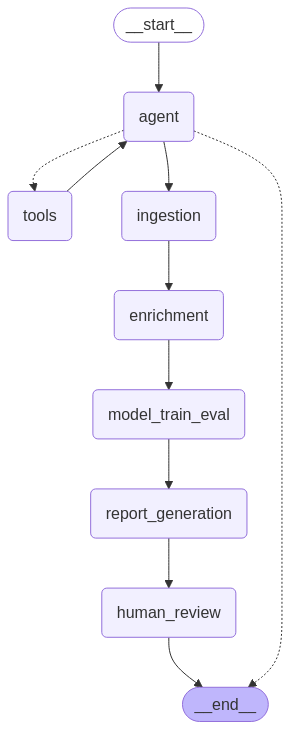

In [137]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [138]:
from IPython.display import Image, display
import os

# Ensure the assets directory exists
os.makedirs("assets", exist_ok=True)

# Save the diagram to a file in the assets folder
graph_png_path = "assets/graph_diagram.png"
try:
    graph_png = app.get_graph().draw_mermaid_png()
    with open(graph_png_path, "wb") as f:
        f.write(graph_png)
    logger.info(f"Graph saved to {graph_png_path}")
except Exception:
    logger.info("Error generating or saving the graph.")

2025-03-27 19:28:29.164 | INFO     | __main__:<module>:13 - Graph saved to assets/graph_diagram.png


In [139]:
app.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': UUID('e09cc17f-0b4d-4008-8449-ee495ef1282b')}}, metadata=None, created_at=None, parent_config=None, tasks=())

================================ Human Message =================================

I need to analyze Nvidia stock data.


2025-03-27 19:28:30.825 | INFO     | __main__:data_ingestion_node:118 - Ingesting data for .
Could not get exchangeTimezoneName for ticker '' reason: 'chart'


================================== Ai Message ==================================
Tool Calls:
  stock_ticker_tool (call_rqwp)
 Call ID: call_rqwp
  Args:
    company_name: Nvidia


$: possibly delisted; no price data found  (period=9mo)
2025-03-27 19:28:36.550 | INFO     | __main__:data_ingestion_node:136 - Raw data ingested: 0 records.
2025-03-27 19:28:36.558 | INFO     | __main__:data_enrichment_node:152 - Enriching data
2025-03-27 19:28:36.565 | ERROR    | __main__:data_enrichment_node:157 - Insufficient raw data for reliable enrichment.


================================= Tool Message =================================
Name: stock_ticker_tool

Successfully added Nvidia's ticker symbol to State


2025-03-27 19:28:37.419 | INFO     | __main__:data_ingestion_node:118 - Ingesting data for NVDA.
2025-03-27 19:28:37.425 | INFO     | __main__:model_training_evaluation_node:258 - Training model with 0 records.
2025-03-27 19:28:37.427 | ERROR    | __main__:model_training_evaluation_node:261 - Enriched data is empty.


================================== Ai Message ==================================

The stock ticker symbol for Nvidia is NVDA. You can use this symbol to analyze Nvidia's stock data.


2025-03-27 19:28:37.754 | INFO     | __main__:data_ingestion_node:136 - Raw data ingested: 187 records.
2025-03-27 19:28:37.766 | INFO     | __main__:data_enrichment_node:152 - Enriching data
2025-03-27 19:28:37.768 | ERROR    | __main__:report_generation_node:416 - ❌ Diagnostic plot bytes not found in state.
2025-03-27 19:28:37.781 | INFO     | __main__:data_enrichment_node:161 - Enriching data for 187 records.
2025-03-27 19:28:37.817 | INFO     | __main__:data_enrichment_node:224 - Data enriched: 167 records available.
2025-03-27 19:28:37.861 | INFO     | __main__:model_training_evaluation_node:258 - Training model with 167 records.
2025-03-27 19:28:37.865 | INFO     | __main__:model_training_evaluation_node:280 - Training Auto ARIMA model.


================================== Ai Message ==================================

The stock ticker symbol for Nvidia is NVDA. You can use this symbol to analyze Nvidia's stock data.
================================== Ai Message ==================================

The stock ticker symbol for Nvidia is NVDA. You can use this symbol to analyze Nvidia's stock data.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=781.188, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=781.740, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=782.254, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=779.238, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=781.863, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=781.988, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=780.612, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=781.132, Time=0.04 sec
 ARIMA(0,1,1

2025-03-27 19:28:44.984 | INFO     | __main__:model_training_evaluation_node:294 - Model saved to state. (Pre-interrupt state)
2025-03-27 19:28:44.991 | INFO     | __main__:model_training_evaluation_node:302 - Test MAE: 8.47565275808181


 ARIMA(2,1,2)(0,0,0)[5]             : AIC=780.762, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[5]          
Total fit time: 7.108 seconds


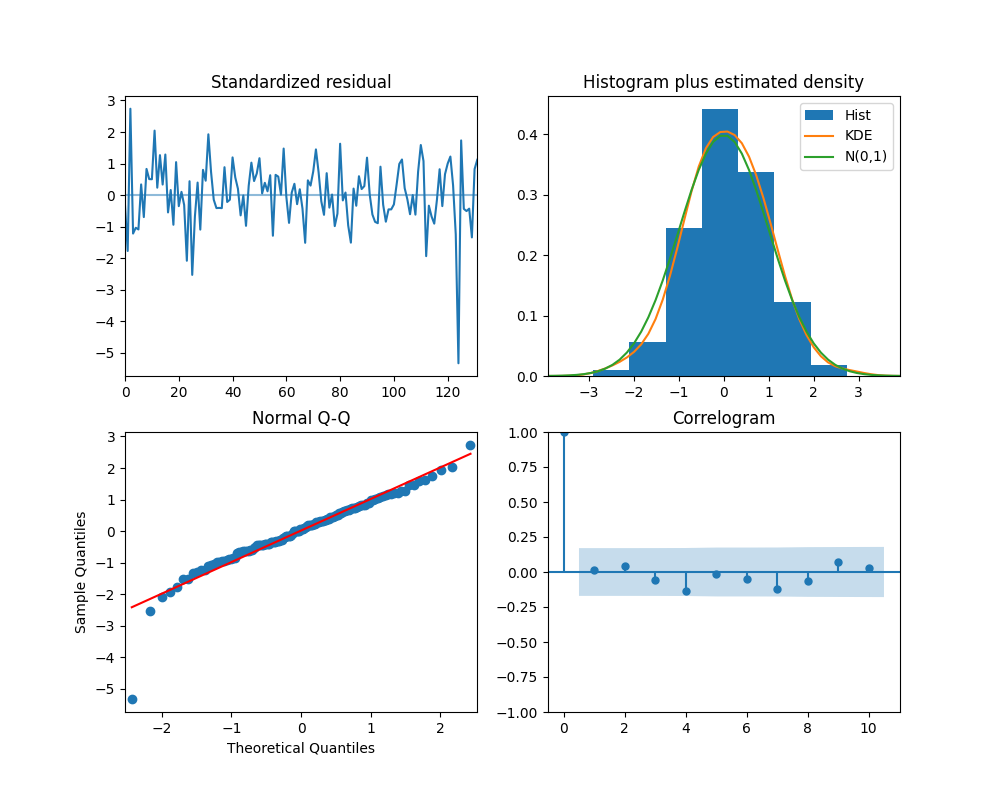

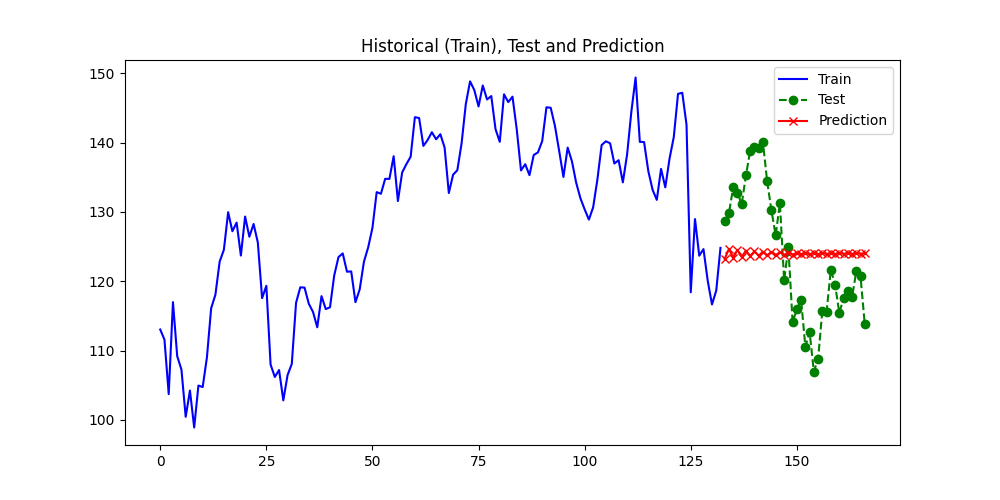

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=979.624, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=979.590, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=980.444, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=977.624, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=981.357, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=981.357, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=983.357, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=977.967, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=978.848, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=976.612, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=978.607, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=978.607, Time=0.27 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=980.609, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=977.247, 

2025-03-27 19:29:21.590 | INFO     | __main__:model_training_evaluation_node:363 - Future forecast: 167    115.723573
168    114.003669
169    113.571020
170    115.127707
171    114.507743
dtype: float64
2025-03-27 19:29:21.591 | INFO     | __main__:model_training_evaluation_node:368 - {'Day 1': 115.72357346975494, 'Day 2': 114.00366869285656, 'Day 3': 113.57102013601026, 'Day 4': 115.12770652267403, 'Day 5': 114.50774315467369}


 ARIMA(3,1,3)(0,0,0)[5]             : AIC=967.966, Time=2.12 sec

Best model:  ARIMA(2,1,2)(0,0,0)[5]          
Total fit time: 35.901 seconds
================================== Ai Message ==================================

The stock ticker symbol for Nvidia is NVDA. You can use this symbol to analyze Nvidia's stock data.


2025-03-27 19:29:23.351 | INFO     | __main__:report_generation_node:486 - Forecast table: ╒═══════╤═══════════════════╕
│ Day   │   Predicted Price │
╞═══════╪═══════════════════╡
│ Day 1 │           115.724 │
├───────┼───────────────────┤
│ Day 2 │           114.004 │
├───────┼───────────────────┤
│ Day 3 │           113.571 │
├───────┼───────────────────┤
│ Day 4 │           115.128 │
├───────┼───────────────────┤
│ Day 5 │           114.508 │
╘═══════╧═══════════════════╛
2025-03-27 19:29:30.562 | ERROR    | __main__:report_generation_node:572 - ❌ Market insights generation error for NVDA: 'latin-1' codec can't encode characters in position 262-290: ordinal not in range(256)


{'messages': [HumanMessage(content='I need to analyze Nvidia stock data.', additional_kwargs={}, response_metadata={}, id='f280f7b7-eba1-42a2-ae3f-235dfbfd6c69'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rqwp', 'function': {'arguments': '{"company_name": "Nvidia"}', 'name': 'stock_ticker_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 279, 'total_tokens': 298, 'completion_time': 0.069090909, 'prompt_time': 0.025072824, 'queue_time': 0.100524913, 'total_time': 0.094163733}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_8dd9fca28c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-46c6e811-aa3f-43a6-813b-9f778f201cb1-0', tool_calls=[{'name': 'stock_ticker_tool', 'args': {'company_name': 'Nvidia'}, 'id': 'call_rqwp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 279, 'output_tokens': 19, 'total_tokens': 298}),
  ToolMessage(content="Successfully added Nvidia's t

In [140]:
# Resume the graph with the edited insights
# Simulate analyst editing the insights:
edited_insights = "These are the analyst's edited insights after review."

query = "I need to analyze Nvidia stock data."
input_data = {
    "messages": [{"role": "user", "content": query}],
    **initial_state
}

# Start the graph execution (this will pause at the interrupt)
events = app.stream(
    input_data,
    config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

# Later, once you have the edited insights:
edited_insights = "These are the analyst's edited insights after review."

# Resume the graph with the edited insights

app.invoke(
    Command(resume={"edited_text": edited_insights}),
    config
)
